**Import libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-06-09 11:53:07.839740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 11:53:07.839843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 11:53:07.982755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_25/4276500669.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_2

In [2]:
# Reading data
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',index_col=[0], parse_dates=[0])

In [3]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
pjme.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


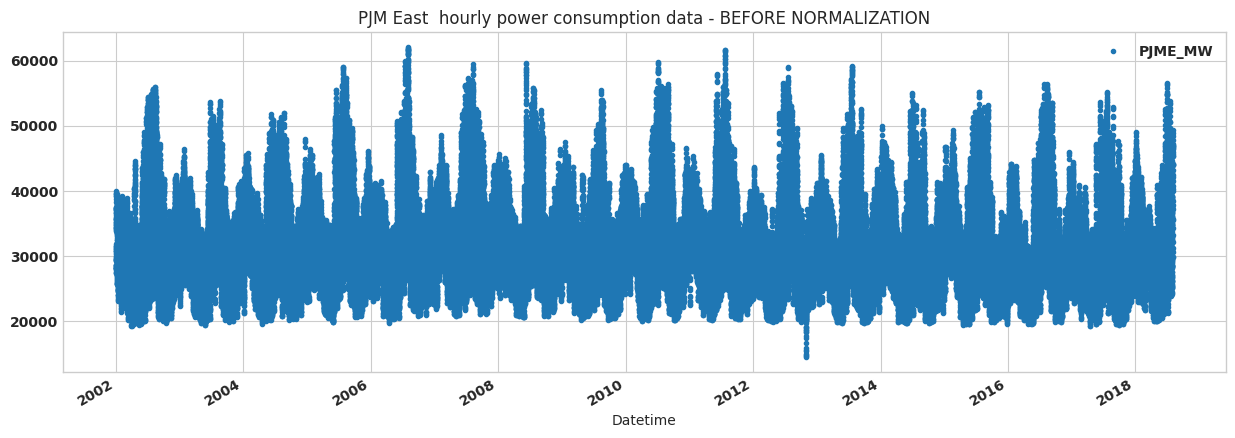

In [5]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [6]:
import sklearn
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

pjme = normalize_data(pjme)
pjme.shape

(145366, 1)

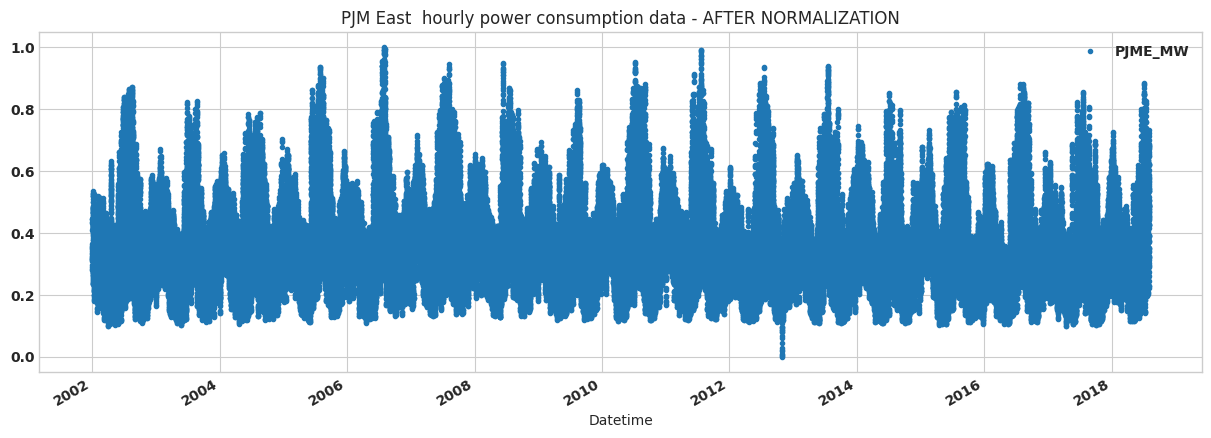

In [7]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - AFTER NORMALIZATION' )
plt.show()

**splitting data**

In [8]:
split_date = '01-Jan-2016'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

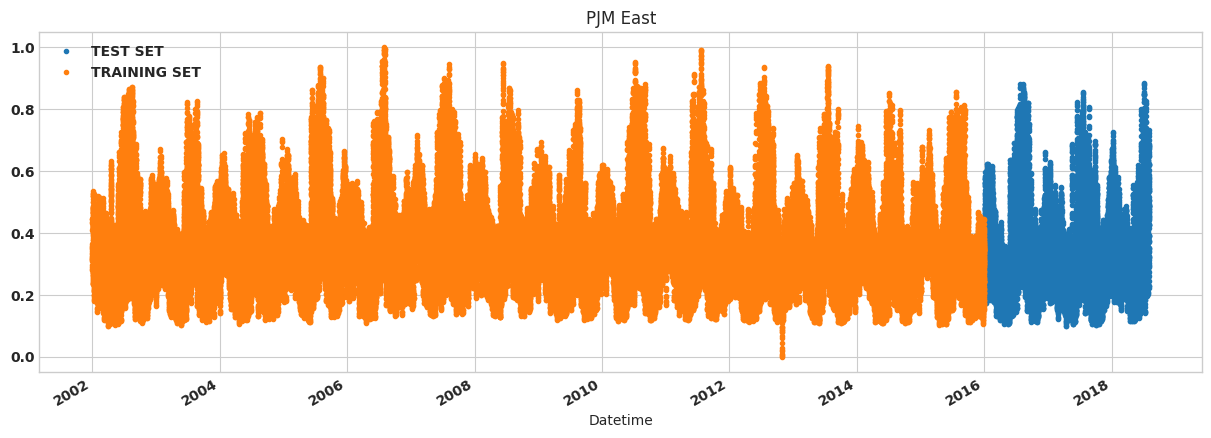

In [9]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [10]:
def load_data(train,test, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(train)):
        X_train.append(train.iloc[i-seq_len : i, 0])
        y_train.append(train.iloc[i, 0])
    
    X_test = []
    y_test = []
    for i in range(seq_len, len(test)):
        X_test.append(test.iloc[i-seq_len : i, 0])
        y_test.append(test.iloc[i, 0])
   
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [11]:
#create train, test data
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(pjme_train , pjme_test , seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (122667, 20, 1)
y_train.shape =  (122667,)
X_test.shape =  (22659, 20, 1)
y_test.shape =  (22659,)


# **Building Models**

**LSTM**

In [12]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.1))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.1))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.1))

lstm_model.add(Dense(1 , activation='linear'))

lstm_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,681 (127.66 KB)

 Trainable params: 32,681 (127.66 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Set the learning rate
learning_rate = 0.001

# Compile the model with the Adam optimizer and the specified learning rate
lstm_optimizer = Adam(learning_rate=learning_rate)
lstm_model.compile(loss='mse', optimizer=lstm_optimizer)

# Earlly Stopping
callback_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer_lstm = callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.keras", verbose=1,
                                         save_best_only=True, monitor='val_loss',mode='min')

**RNN**

In [14]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1, activation='linear'))

rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201 (32.04 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
rnn_optimizer = Adam(learning_rate=learning_rate)
rnn_model.compile(loss='mse', optimizer=rnn_optimizer)

# Earlly Stopping
callback_rnn = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer_rnn = callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.keras", verbose=1,
                                         save_best_only=True, monitor='val_loss',mode='min')

**fit**

In [16]:
# Train the model
historylstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32 ,validation_split = 0.1, callbacks=[callback_lstm , checkpointer_lstm])

Epoch 1/100
3445/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 1: val_loss improved from inf to 0.00080, saving model to ./checkpoint-01.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0073 - val_loss: 7.9556e-04
Epoch 2/100
3446/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6204e-04
Epoch 2: val_loss improved from 0.00080 to 0.00039, saving model to ./checkpoint-02.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 7.6194e-04 - val_loss: 3.9139e-04
Epoch 3/100
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5973e-04
Epoch 3: val_loss improved from 0.00039 to 0.00035, saving model to ./checkpoint-03.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 5.5973e-04 - val_loss: 3.5403e-04
Epoch 4/100
3449/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9722e-04
Epoch 4: val_loss improved from 0.00035 to 0.00034, saving model to ./checkpoint-04.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 4.9721e-04 - val_loss: 3.4024e-04
Epoch 5/100


In [17]:
# Train the model
historyrnn = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32 ,validation_split = 0.1, callbacks=[callback_rnn , checkpointer_rnn])

Epoch 1/100
  28/3450 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.3787

I0000 00:00:1717935326.623513      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3447/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0362
Epoch 1: val_loss improved from inf to 0.00042, saving model to ./checkpoint-01.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.0362 - val_loss: 4.1787e-04
Epoch 2/100
3445/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1033e-04
Epoch 2: val_loss improved from 0.00042 to 0.00040, saving model to ./checkpoint-02.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 9.1015e-04 - val_loss: 4.0153e-04
Epoch 3/100
3449/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6820e-04
Epoch 3: val_loss did not improve from 0.00040
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 6.6819e-04 - val_loss: 4.5703e-04
Epoch 4/100
3446/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2019e-04
Epoch 4: val_loss did not improve from 0.00040
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 6.2019e-04 - val_loss: 4.3982e-04
Epoch 5/100
3447/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1388e-04
Epoch 5: val_loss did not improve fr

**Models Evaluation**

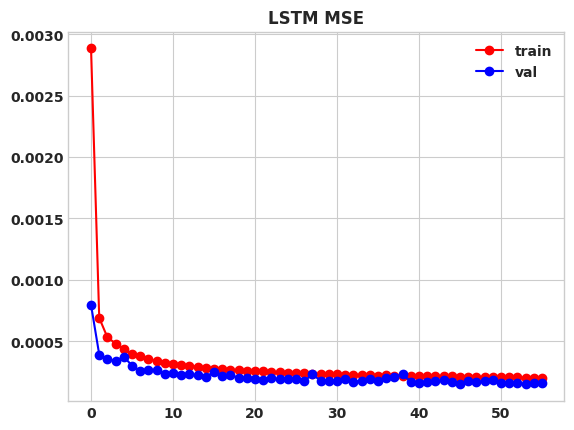

In [18]:
# plot history
plt.plot(historylstm.history['loss'],'r-o', label='train')
plt.plot(historylstm.history['val_loss'],'b-o', label='val')
plt.legend()
plt.title("LSTM MSE" , weight='bold')
plt.show()

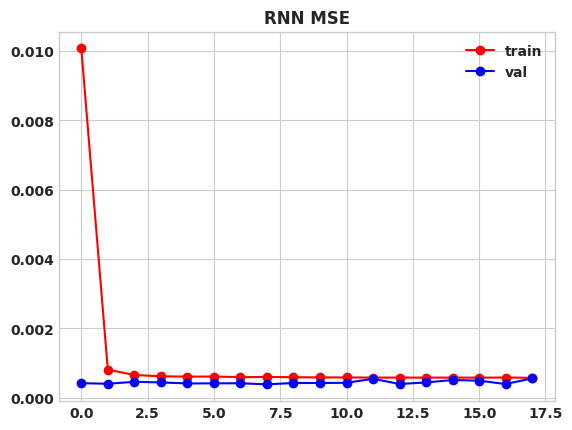

In [19]:
# plot history
plt.plot(historyrnn.history['loss'],'r-o', label='train')
plt.plot(historyrnn.history['val_loss'],'b-o', label='val')
plt.legend()
plt.title("RNN MSE" , weight='bold')
plt.show()

In [20]:
# make a prediction
yhat_train_lstm = lstm_model.predict(X_train)
# make a prediction
yhat_train_rnn = rnn_model.predict(X_train)

3834/3834 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [21]:
import sklearn.metrics as skm
from math import sqrt

def model_metrics(target: pd.DataFrame, predictions: []) -> None:
    print("Explained variance regression score: %.3f" %skm.explained_variance_score(target, predictions))
    print("Maximum residual error: %.3f" %skm.max_error(target, predictions))
    print("Mean squared error: %.3f" %skm.mean_squared_error(target, predictions))
    print("R2 Score: %.3f" %skm.r2_score(target, predictions))
    print("Root-mean-square Error: %.3f" %sqrt(skm.mean_squared_error(target, predictions)))
    print("Median_absolute_error: %.3f" %skm.median_absolute_error(target , predictions))
    print("Mean_absolute_error: %.3f" %skm.mean_absolute_error(target , predictions))

In [22]:
# Test Set 
yhat_l = lstm_model.predict(X_test)
# Test Set 
yhat_r = rnn_model.predict(X_test)

709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [23]:
print("***  LSTM Evaluation ***** ")
model_metrics(y_test , yhat_l)
print("********************* ")
print("********************* ")
print("********************* ")
print("***  RNN Evaluation ***** ")
model_metrics(y_test , yhat_r)

***  LSTM Evaluation ***** 
Explained variance regression score: 0.991
Maximum residual error: 0.244
Mean squared error: 0.000
R2 Score: 0.991
Root-mean-square Error: 0.013
Median_absolute_error: 0.005
Mean_absolute_error: 0.007
********************* 
********************* 
********************* 
***  RNN Evaluation ***** 
Explained variance regression score: 0.978
Maximum residual error: 0.256
Mean squared error: 0.001
R2 Score: 0.971
Root-mean-square Error: 0.023
Median_absolute_error: 0.014
Mean_absolute_error: 0.017


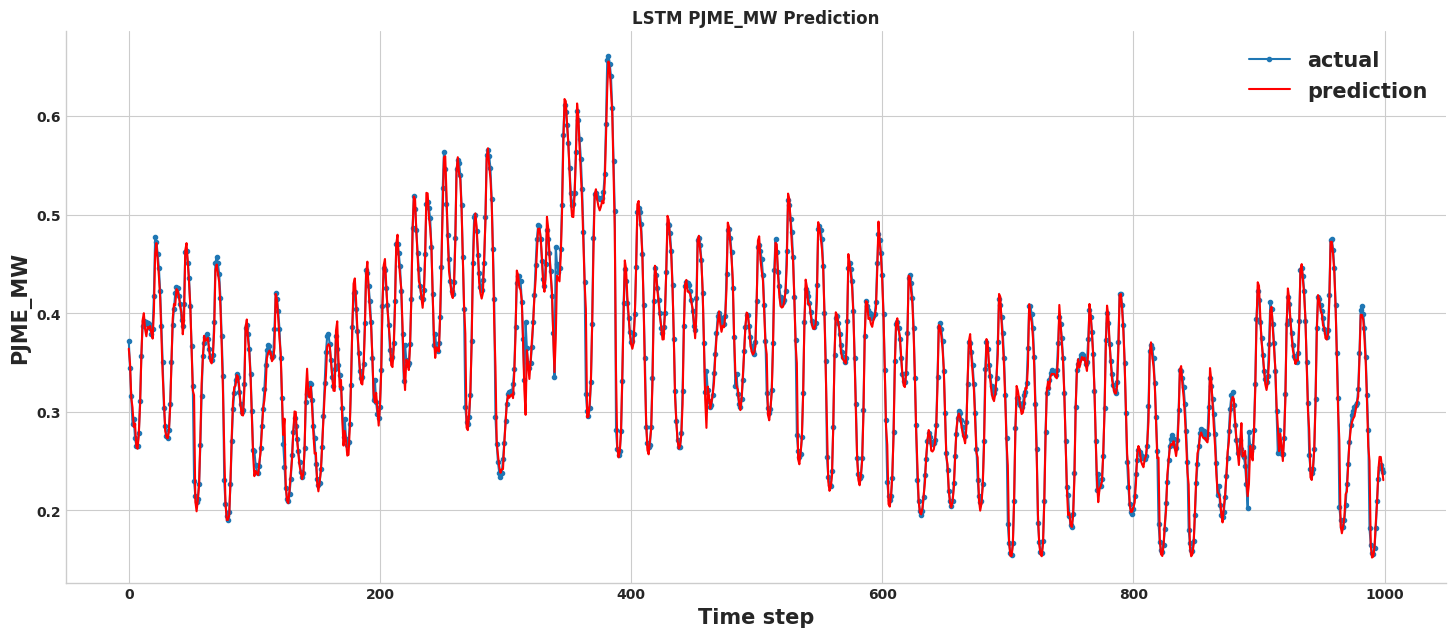

In [24]:
plt.figure(figsize=(15,6))
plt.plot( y_test[:1000], marker='.', label="actual")
plt.plot( yhat_l[:1000], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15 , weight='bold')
plt.xlabel('Time step', size=15 , weight='bold')
plt.legend(fontsize=15)
plt.title("LSTM PJME_MW Prediction" , weight='bold')
plt.show();

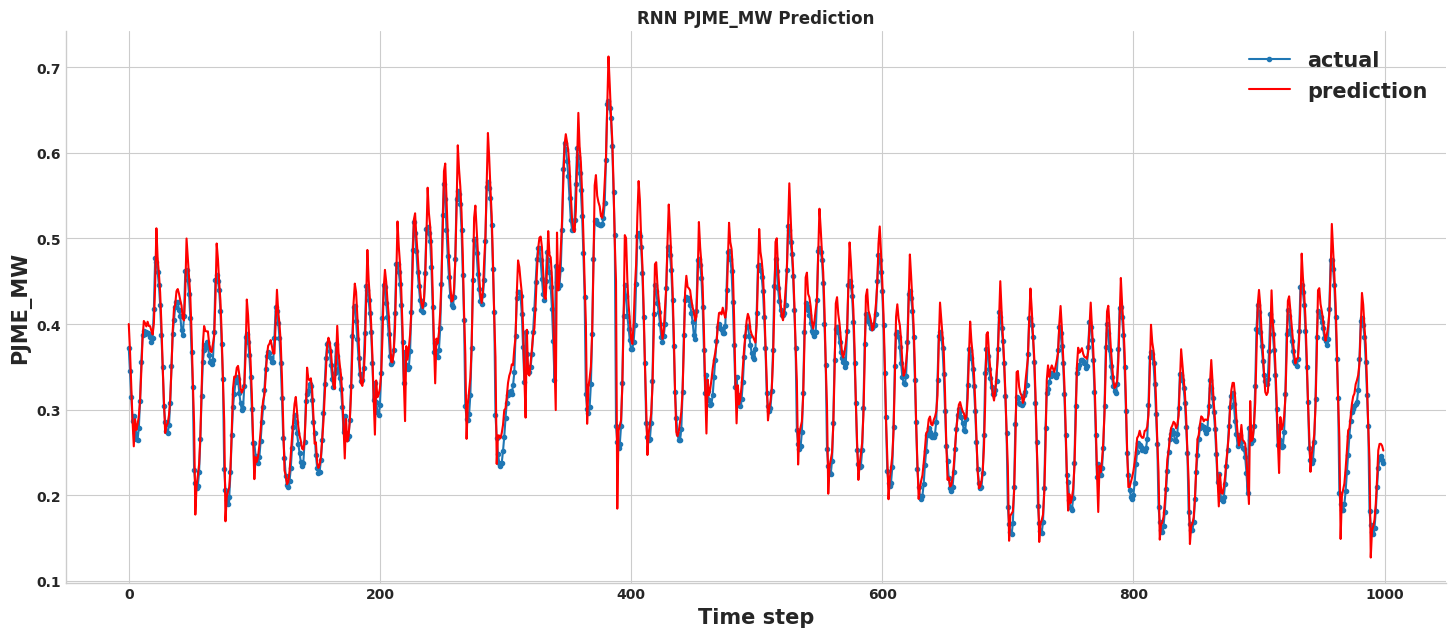

In [25]:
plt.figure(figsize=(15,6))
plt.plot( y_test[:1000], marker='.', label="actual")
plt.plot( yhat_r[:1000], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15 , weight='bold')
plt.xlabel('Time step', size=15 , weight='bold')
plt.legend(fontsize=15)
plt.title("RNN PJME_MW Prediction" , weight='bold')
plt.show();